In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import shutil
import zipfile
import os
import cv2
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
os.listdir('/kaggle/input/dogs-vs-cats-redux-kernels-edition')

['sample_submission.csv', 'train.zip', 'test.zip']

In [3]:
os.getcwd() # 현재 dir위치

'/kaggle/working'

In [4]:
#shutil.rmtree('../data') #처음돌릴때는 이 줄을 주석처리하시오.
os.makedirs('../data') # 최상위 폴더에 data 폴더 만듬

In [5]:
base_dir = '../input/dogs-vs-cats-redux-kernels-edition'
train_dir = '../data/train'
val_dir = '../data/val'
test_dir = '../data/test'


train_dog_dir = '../data/train/dog'
train_cat_dir = '../data/train/cat'
val_dog_dir = '../data/val/dog'
val_cat_dir = '../data/val/cat'

In [6]:
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data') #train_zip을 train_zip으로 설정한후, 압축 해제해서 data폴더에 넣어버림.

os.makedirs(test_dir)
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

In [7]:
os.makedirs(val_dir,exist_ok=True)
os.makedirs(train_dog_dir,exist_ok=True)
os.makedirs(train_cat_dir,exist_ok=True)
os.makedirs(val_dog_dir,exist_ok=True)
os.makedirs(val_cat_dir,exist_ok=True)

In [8]:
os.listdir(train_dir)[:5]
os.listdir(test_dir)[:5]

['10435.jpg', '6790.jpg', '4644.jpg', '1835.jpg', '1102.jpg']

In [9]:
os.getcwd() # 현재 dir위치 여기서 ../data하면 data폴더로, ../input하면 input 폴더로 들어간다.

'/kaggle/working'

In [10]:
#ori_train_size = len(os.listdir(train_dir))
ori_train_size =25000 #이유는 모르겠지만 25000개가 아닌 25002개가 나와서 그냥 넣기로함.
test_size = len(os.listdir(test_dir))
print(test_size)

12500


In [11]:
val_ratio = 0.2

dog_files = [f'dog.{i}.jpg' for i in range(ori_train_size//2)]
cat_files = [f'cat.{i}.jpg' for i in range(ori_train_size//2)]

test_files = [f'{i}.jpg' for i in range(1,test_size+1)]

In [12]:
import shutil
val_size = int(ori_train_size*val_ratio)
train_size = int(ori_train_size-val_size)
train_animal_size = train_size//2
val_animal_size = val_size//2

for file in dog_files[:train_animal_size]:
    src = os.path.join(train_dir, file)
    dst = os.path.join(train_dog_dir, file)
    shutil.move(src, dst)
for file in cat_files[:train_animal_size]:
    src = os.path.join(train_dir, file)
    dst = os.path.join(train_cat_dir, file)
    shutil.move(src, dst)

for file in dog_files[train_animal_size:]:
    src = os.path.join(train_dir, file)
    dst = os.path.join(val_dog_dir, file)
    shutil.move(src, dst)
for file in cat_files[train_animal_size:]:
    src = os.path.join(train_dir, file)
    dst = os.path.join(val_cat_dir, file)
    shutil.move(src, dst)

    

In [13]:
os.listdir(test_dir)[:5]

['10435.jpg', '6790.jpg', '4644.jpg', '1835.jpg', '1102.jpg']

In [14]:
import tensorflow as tf
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                rotation_range=40,
                                                                brightness_range = [0.5,1.0],
                                                                zoom_range = [0.5,1.0],
                                                                horizontal_flip = True,
                                                               )
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
 

image_size = 128
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(image_size,image_size),batch_size=32,class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(val_dir,target_size=(image_size,image_size),batch_size=32,class_mode='binary')
#test_generator = test_datagen.flow_from_directory(test_dir,target_size=(image_size,image_size),batch_size=32,class_mode='binary')
 
train_step = train_generator.n // 32
valid_step = valid_generator.n // 32
#test_step = test_generator.n // 32

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(image_size,image_size,3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                    

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [17]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 7, mode = 'auto')

In [18]:
hist = model.fit(train_generator,
                steps_per_epoch=train_step,
                epochs=100,
                validation_data=valid_generator,
                validation_steps=valid_step,
                callbacks = [early_stopping]
                )


Epoch 1/100
625/625 [==============================] - 140s 204ms/step - loss: 0.6938 - acc: 0.4998 - val_loss: 0.6930 - val_acc: 0.5002
Epoch 2/100
625/625 [==============================] - 130s 207ms/step - loss: 0.6933 - acc: 0.5013 - val_loss: 0.6931 - val_acc: 0.4998
Epoch 3/100
625/625 [==============================] - 131s 210ms/step - loss: 0.6931 - acc: 0.5071 - val_loss: 0.6930 - val_acc: 0.4998
Epoch 4/100
625/625 [==============================] - 132s 211ms/step - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6930 - val_acc: 0.4998
Epoch 5/100
625/625 [==============================] - 132s 211ms/step - loss: 0.6931 - acc: 0.5070 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 6/100
625/625 [==============================] - 132s 211ms/step - loss: 0.6933 - acc: 0.5044 - val_loss: 0.6929 - val_acc: 0.4998
Epoch 7/100
625/625 [==============================] - 130s 208ms/step - loss: 0.6931 - acc: 0.5067 - val_loss: 0.6927 - val_acc: 0.5000
Epoch 8/100
625/625 [====================

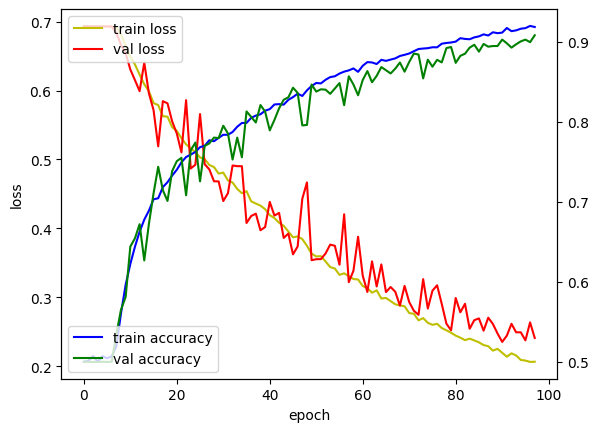

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(hist.history['acc'], 'b', label = 'train accuracy')
acc_ax.plot(hist.history['val_acc'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

In [20]:
#model.save('/kaggle/working/first_cnn.h5')

In [21]:
paths=[]
for file_name in test_files:
    path = test_dir+'/'+file_name
    paths.append(path)

test_df= pd.DataFrame({'path':paths})


eval_generator = test_datagen.flow_from_dataframe(dataframe=test_df,x_col='path',target_size=(image_size,image_size),batch_size=32,class_mode=None,shuffle=False)
pred = model.predict(eval_generator, steps=12500)

Found 12500 validated image filenames.
12500/12500 [==============================] - 20s 2ms/step


In [22]:
#pred = np.clip(pred, 0.01, 0.99)

In [23]:
id = np.array([[i for i in range(1, len(pred)+1)]], dtype=np.int32).reshape(-1,)
print(id)
submission = pd.DataFrame()
submission['id'] = id
submission['label'] = pred
submission.head()

[    1     2     3 ... 12498 12499 12500]


,id,label
0,1,0.632110
1,2,0.999996
2,3,0.999984
3,4,0.999200
4,5,0.001660


In [24]:
submission.to_csv('submission.csv', index=False)
print('submit finish')

submit finish
